In [1]:
# 사용방법 - 복사하여 주석만 제거하여 사용
import sys
from pathlib import Path

# 현재 노트북(.ipynb)이 src/ 안에 있으니 상위 폴더(프로젝트 루트)를 추가
BASE_DIR    = Path().resolve().parent.parent    # Notebook이 src/ 안이라면 .parent
config_path = BASE_DIR / 'config' / 'data_paths.yaml'
sys.path.insert(0, str(BASE_DIR))


# 이제 바로 import
from scripts.data_loader import load_data
df_pm10 = load_data('pm10')

In [ ]:
import pandas as pd

# 구분 컬럼을 날짜 형태로 변환하고, 연도와 월 컬럼 추가
df_pm10['구분'] = pd.to_datetime(df_pm10['구분'].str.replace(' 월', ''), format='%Y.%m')
df_pm10 = df_pm10.rename(columns={'구분': 'date'})

# 결측치가 너무 많은 도시는 제거하고 평균값 상위 10개만 분석
threshold = df_pm10.shape[0] * 0.9  # 90% 이상 데이터가 있어야 유지
valid_cities = df_pm10.drop(columns='date').count()[lambda x: x > threshold].index.tolist()

# 상위 10개 평균 PM10 도출
top10_avg_pm10 = (
    df_pm10[valid_cities]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# 이 도시들의 월별 추이 분석을 위한 데이터셋 구성
df_pm10_top10 = df_pm10[['date'] + top10_avg_pm10]

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 시계열 그래프 그리기
plt.figure(figsize=(14, 6))
for city in top10_avg_pm10:
    plt.plot(df_pm10_top10['date'], df_pm10_top10[city], label=city)

plt.title('도시별 월별 PM10 추이 (상위 10개 도시)')
plt.xlabel('날짜')
plt.ylabel('PM10 농도')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Users\김남준\AppData\Local\Temp\ipykernel_4344\4006184567.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['구분'].str.replace(" 월", ""), format="%Y.%m")


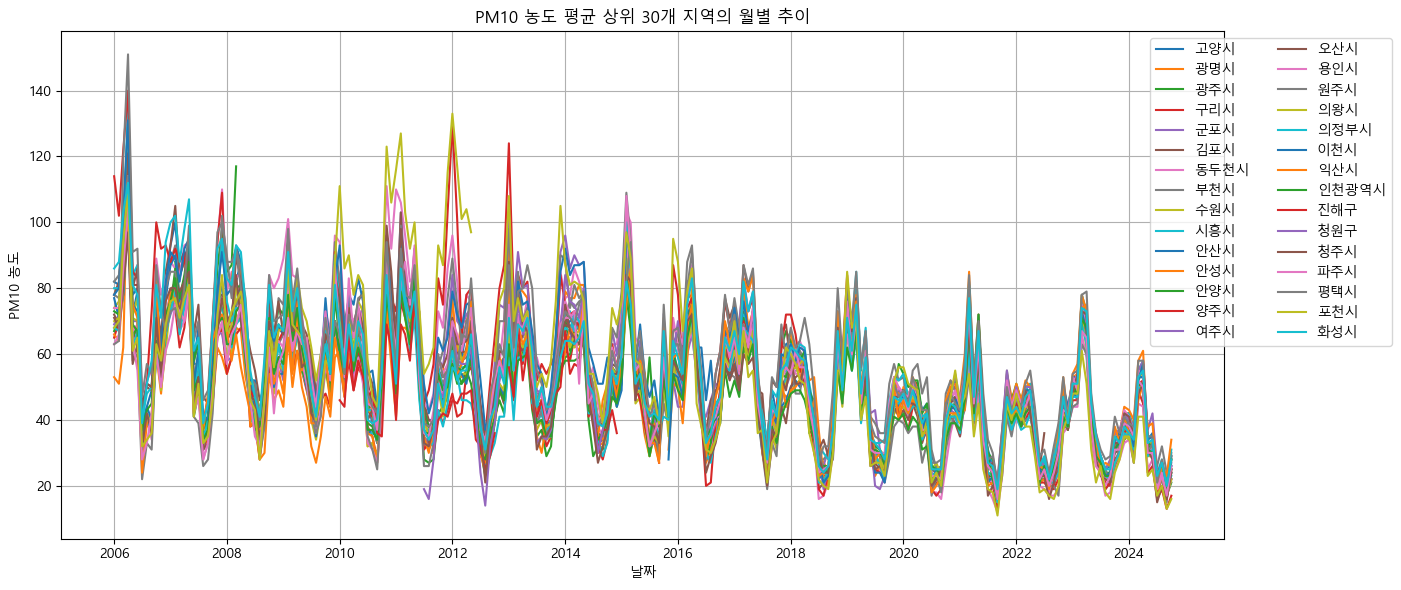

In [ ]:
# 필요한 데이터 재정의
# df = load_data('pm10', section='raw')

df = load_data('pm10_rename_region', section='processed')
df_long = df.melt(id_vars='구분', var_name='region', value_name='pm10')
df_long['pm10'] = pd.to_numeric(df_long['pm10'], errors='coerce')

# 하위 30개 평균값 기준으로 필터링
# 평균이 낮은 지역부터 상위 30개 추출
avg_pm10 = (
    df_long.groupby('region')['pm10']
    .mean()
    .sort_values(ascending=False)
    .head(30)
    .reset_index()
)
# 추이 시각화를 위한 데이터 구성
df_filtered = df_long[df_long['region'].isin(avg_pm10['region'])]

# 날짜 파싱 및 피벗
df_filtered['date'] = pd.to_datetime(df_filtered['구분'].str.replace(" 월", ""), format="%Y.%m")
df_pivot = df_filtered.pivot(index='date', columns='region', values='pm10')

# 시각화
plt.figure(figsize=(14, 6))
for region in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[region], label=region)

plt.title('PM10 농도 평균 상위 30개 지역의 월별 추이')
plt.xlabel('날짜')
plt.ylabel('PM10 농도')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 천식 데이터 전체 로드 (앞에서는 일부만 불러왔음)
df_asthma = load_data('asthma')


# 열 이름 통일
df_asthma = df_asthma.rename(columns={
    '요양개시연월': 'date',
    '시도명': '시도',
    '시군구명': '시군구',
    '진료에피소드 건수': '진료건수'
})

# 날짜 변환
df_asthma['date'] = pd.to_datetime(df_asthma['date'])

# 진료건수 월별 + 지역별 집계
asthma_monthly = (
    df_asthma.groupby(['date', '시군구'])['진료건수']
    .sum()
    .reset_index()
    .rename(columns={'시군구': 'region'})
)

# PM10 데이터 정리
df_long['date'] = pd.to_datetime(df_long['구분'].str.replace(" 월", ""), format="%Y.%m")
pm10_monthly = (
    df_long.groupby(['date', 'region'])['pm10']
    .mean()
    .reset_index()
)

# 병합
df_merged = pd.merge(pm10_monthly, asthma_monthly, on=['date', 'region'])

# 상위 30개 지역 기준 필터링
top30_regions = df_long['region'].tolist()
df_top30_merged = df_merged[df_merged['region'].isin(top30_regions)]

# 상관관계 계산
correlations = df_top30_merged.groupby('region')[['pm10', '진료건수']].corr().iloc[0::2, 1].reset_index()
correlations = correlations[['region', '진료건수']].rename(columns={'진료건수': '상관계수'})


In [15]:
print(correlations)

    region      상관계수
0      가평군  0.545926
1      강릉시  0.505777
2      강진군  0.083637
3      거제시  0.563023
4      거창군  0.579672
..     ...       ...
137    홍천군  0.356155
138    화성시  0.254293
139    화순군  0.547213
140    화천군  0.212267
141    횡성군  0.485427

[142 rows x 2 columns]


In [ ]:
import prophet 
# 예측 대상 지역 중 상관계수가 높은 지역 하나 예시 선택 (예: 화순군)
selected_region = "거창군"

# 예측용 데이터 준비
df_predict = df_long[df_long['region'] == selected_region][['date', 'pm10']].dropna()
df_predict = df_predict.rename(columns={'date': 'ds', 'pm10': 'y'})

# Prophet 모델 학습
model = Prophet()
model.fit(df_predict)

# 향후 12개월 예측
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# 시각화
fig = model.plot(forecast)
plt.title(f"{selected_region} PM10 농도 예측 (향후 12개월)")
plt.xlabel("날짜")
plt.ylabel("PM10 농도")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'Prophet' is not defined

In [17]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --------- ------------------------------ 3.1/13.3 MB 23.1 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/13.3 MB 14.1 MB/s eta 0:00:01
   ---------------------------------- ----- 11.5/13.3 MB 19.0 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 14.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   --------------------------------------- 954.8/954.8 kB 22.3 MB/s eta 0:00:00


C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


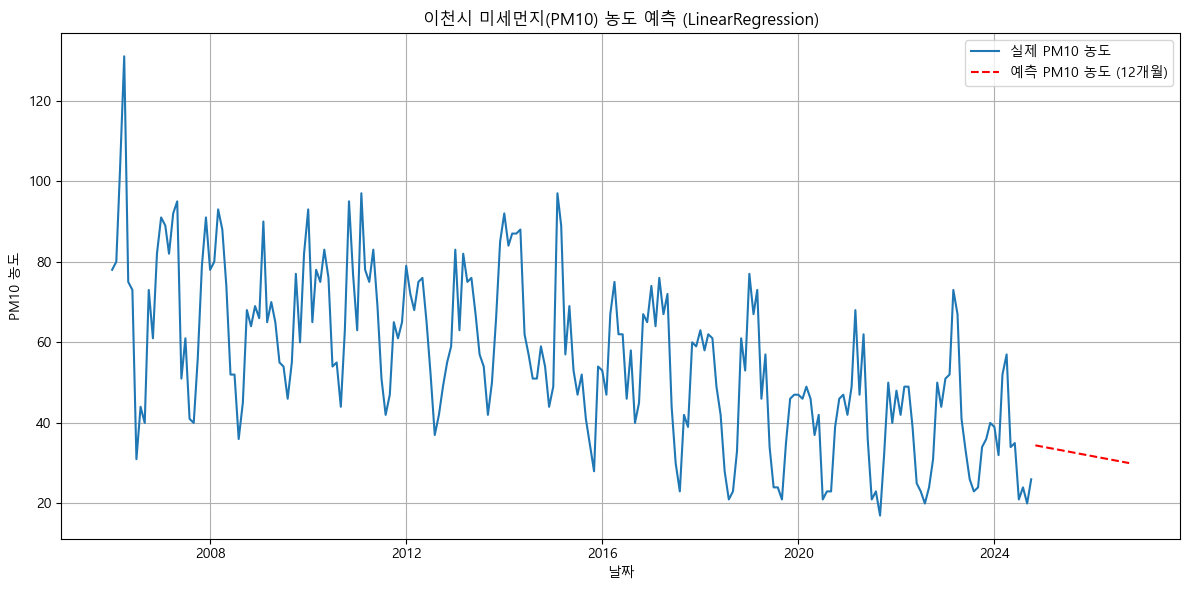

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# df_long에 'date' 컬럼이 없으므로 다시 생성 후 예측 코드 재실행
df_long['date'] = pd.to_datetime(df_long['구분'].str.replace(" 월", ""), format="%Y.%m")

# 화순군 데이터 추출 및 전처리
df_region = df_long[df_long['region'] == "이천시"][['date', 'pm10']].dropna()
df_region = df_region.sort_values('date')
df_region['date_ordinal'] = df_region['date'].map(pd.Timestamp.toordinal)

# 선형 회귀 학습
X = df_region[['date_ordinal']]
y = df_region['pm10']
model = LinearRegression()
model.fit(X, y)

# 향후 12개월 날짜 생성 및 변환
future_dates = pd.date_range(start=df_region['date'].max() + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_ordinal = future_dates.map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)
future_pred = model.predict(future_ordinal)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_region['date'], df_region['pm10'], label='실제 PM10 농도')
plt.plot(future_dates, future_pred, label='예측 PM10 농도 (12개월)', linestyle='--', color='red')
plt.title('이천시 미세먼지(PM10) 농도 예측 (LinearRegression)')
plt.xlabel('날짜')
plt.ylabel('PM10 농도')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Importing plotly failed. Interactive plots will not work.


In [25]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [26]:
from prophet import Prophet

In [30]:
# PM10 데이터 준비
df_pm10 = df_long[df_long['region'] == '이천시'][['date', 'pm10']].dropna()
df_pm10 = df_pm10.rename(columns={'date': 'ds', 'pm10': 'y'})

# 진료 데이터 준비
df_asthma_ic = df_asthma[df_asthma['시군구'] == '이천시'][['date', '진료건수']].dropna()
df_asthma_ic.columns = ['ds', 'asthma_cases']
df_asthma_ic['ds'] = pd.to_datetime(df_asthma_ic['ds'])

# 병합
df_merge = pd.merge(df_pm10, df_asthma_ic, on='ds', how='inner')

16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


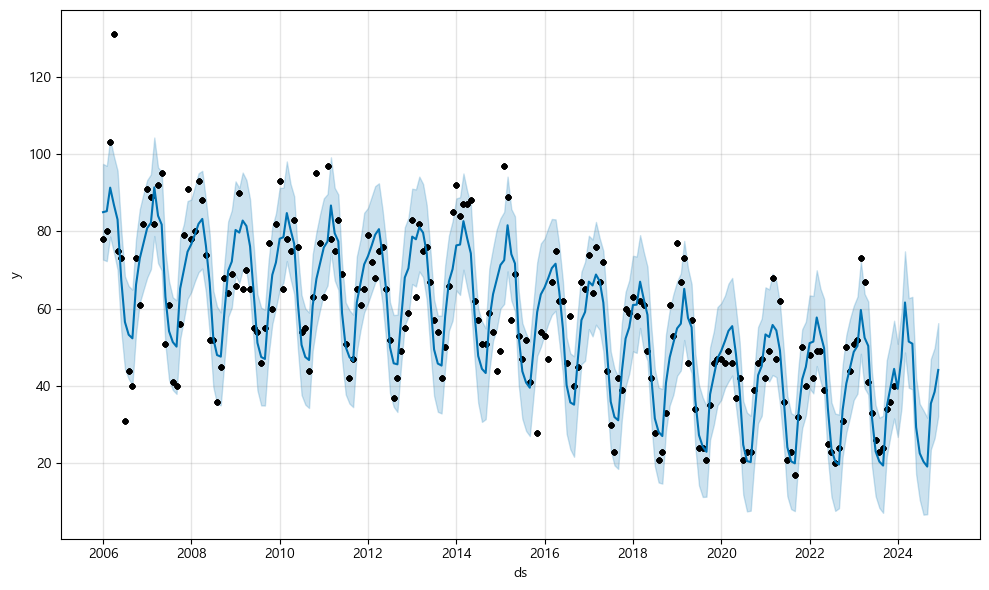

In [31]:
model = Prophet()
model.add_regressor('asthma_cases')  # 외부 변수 추가
model.fit(df_merge)

# 향후 12개월 예측용 외부 변수도 필요
future = model.make_future_dataframe(periods=12, freq='M')

# 외부 변수도 미래값까지 채워야 함
# 아래는 단순히 마지막 값으로 채우는 예시
last_known = df_merge['asthma_cases'].iloc[-1]
future['asthma_cases'] = [last_known] * len(future)

forecast = model.predict(future)
fig = model.plot(forecast)

In [33]:
# Prophet을 위한 데이터 준비 (이천시 + 천식 진료건수)
df_long['date'] = pd.to_datetime(df_long['구분'].str.replace(" 월", ""), format="%Y.%m")
df_pm10 = df_long[df_long['region'] == '이천시'][['date', 'pm10']].dropna()
df_pm10 = df_pm10.rename(columns={'date': 'ds', 'pm10': 'y'})

df_asthma = load_data('asthma')

# 진료 데이터 준비
df_asthma_ic = df_asthma[df_asthma['시군구'] == '이천시'][['date', '진료건수']].dropna()
df_asthma_ic.columns = ['ds', 'asthma_cases']
df_asthma_ic['ds'] = pd.to_datetime(df_asthma_ic['ds'])

# 병합
df_merge = pd.merge(df_pm10, df_asthma_ic[['ds', 'asthma_cases']], on='ds', how='inner')

# Prophet 모델 구성 및 학습
model = Prophet()
model.add_regressor('asthma_cases')
model.fit(df_merge)

# 향후 12개월 예측
future = model.make_future_dataframe(periods=12, freq='M')
last_known = df_merge['asthma_cases'].iloc[-1]
future['asthma_cases'] = [last_known] * len(future)

forecast = model.predict(future)


KeyError: '시군구'

In [34]:
# df_long 자체에 date 컬럼이 없었다면 생성
df_long['date'] = pd.to_datetime(
    df_long['구분'].str.replace(" 월", ""), format="%Y.%m"
)
# Prophet(또는 merge)에서 ds라고 부를 것이므로 rename
df_pm10 = (
    df_long[df_long['region'] == '이천시'][['date', 'pm10']]
    .dropna()
    .rename(columns={'date': 'ds', 'pm10': 'y'})
)

# (이전에) 다음과 같이 컬럼명을 통일했는지 확인
df_asthma = df_asthma.rename(columns={
    '요양개시연월': 'date',
    '시도명': '시도',
    '시군구명': '시군구',
    '진료에피소드 건수': '진료건수'
})
# 날짜 타입으로 변환
df_asthma['date'] = pd.to_datetime(df_asthma['date'])

# 이천시 데이터만 뽑아서 merge용 이름으로 변경
df_asthma_ic = (
    df_asthma[df_asthma['시군구'] == '이천시']
    [['date', '진료건수']]
    .dropna()
    .rename(columns={'date': 'ds', '진료건수': 'asthma_cases'})
)



In [35]:
df_merge = pd.merge(df_pm10, df_asthma_ic, on='ds', how='inner')

In [36]:
df_merge

,ds,y,asthma_cases
0,2006-01-01,78.0,286
1,2006-01-01,78.0,126
2,2006-01-01,78.0,14
3,2006-01-01,78.0,84
4,2006-01-01,78.0,137
...,...,...,...
2574,2023-12-01,40.0,38
2575,2023-12-01,40.0,7
2576,2023-12-01,40.0,64
2577,2023-12-01,40.0,71


17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


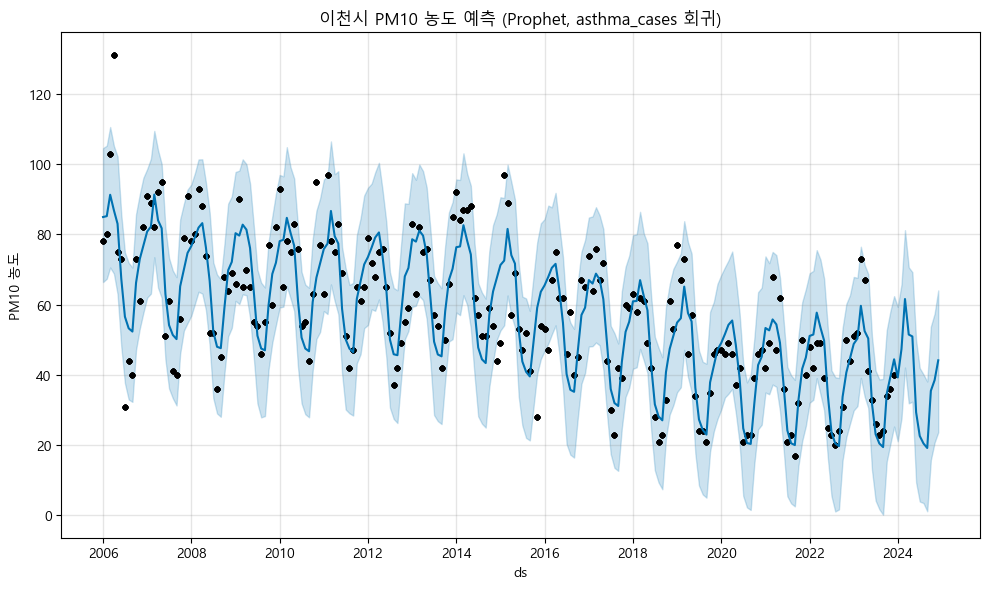

        ds      yhat  yhat_lower  yhat_upper
2023-12-31 39.292903   21.105416   59.385792
2024-01-31 47.382212   27.614621   65.744340
2024-02-29 61.617423   42.109193   81.226080
2024-03-31 51.509835   31.918902   70.644536
2024-04-30 50.961036   32.387673   69.272710
2024-05-31 29.373598    9.430367   49.878612
2024-06-30 22.634572    3.972489   41.970351
2024-07-31 20.487632    3.526249   40.146558
2024-08-31 19.205433    1.188083   38.138606
2024-09-30 35.504037   15.800651   53.782344
2024-10-31 38.516937   20.769131   57.439595
2024-11-30 44.168985   23.670334   64.069355


In [ ]:
# 1) Prophet 임포트
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# 2) df_merge 준비(이미 생성하신 상태)
#    df_merge.columns == ['ds', 'y', 'asthma_cases']

# 3) 모델 초기화 및 외부회귀변수 등록
model = Prophet(interval_width=0.95)   # 신뢰구간 95%
model.add_regressor('asthma_cases')

# 4) 학습
model.fit(df_merge)

# 5) 미래 프레임 생성 (12개월)
future = model.make_future_dataframe(periods=12, freq='M')

#    외부변수도 동일하게 연장(여기서는 마지막 관측값으로 채움)
last_asthma = df_merge['asthma_cases'].iloc[-1]
future['asthma_cases'] = last_asthma

# 6) 예측
forecast = model.predict(future)

# 7) 결과 시각화
fig = model.plot(forecast)
ax = fig.gca()
ax.set_title("이천시 PM10 농도 예측 (Prophet, asthma_cases 회귀)")
ax.set_ylabel("PM10 농도")
plt.tight_layout()
plt.show()

# 8) 예측값 및 신뢰구간 수치 추출 (마지막 12개월)
result = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12)
print(result.to_string(index=False))



In [41]:
import pandas as pd
from pathlib import Path
from datetime import datetime

#—(1) 저장할 파일명 및 경로 설정————————————
today    = datetime.now().strftime('%Y%m%d')
filename = f"pm10_icheon.csv"

# 프로젝트 루트 아래 data/processed 폴더로 지정
out_dir  = BASE_DIR / 'data' / 'processed'
out_dir.mkdir(parents=True, exist_ok=True)  # 폴더가 없으면 생성

out_path = out_dir / filename
#—————————————————————————————

#—(2) CSV로 저장————————————
# avg_pm10_filtered: 앞서 만든 DataFrame 변수명
df_merge.to_csv(
    out_path, 
    index=False, 
    encoding='utf-8-sig'   # 한글깨짐 방지
)

print(f"Top30 PM10 결과를 저장했습니다: {out_path}")

Top30 PM10 결과를 저장했습니다: C:\team_project\dust\data\processed\pm10_icheon.csv
